## Titanic Data set - Logistic Regression with Python
I will be using Titanic Data Set from Kaggle. 

Here I will be trying to predict a classification- survival or deceased. 

In [48]:
import numpy as np
import pandas as pd
from io import StringIO, BytesIO
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data
Let's start by reading in the titanic_df.csv file into a pandas dataframe.

In [51]:
df=pd.read_csv("titanic.csv")

In [52]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Exploratory Data Analysis
Let's begin some exploratory data analysis! With checking out missing data!

## Missing Data
I will use seaborn to create a simple heatmap to see where we are missing data!

### Checking the null/ missing values

In [54]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [55]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

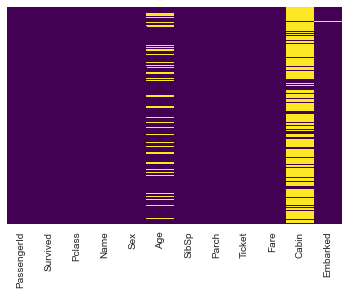

In [56]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
#yticklabels: removes the y axis labels
#cbar: removes the colorbar
#cmap: shows the visualization in the yellow and voilet 

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0"

In [57]:
#checking the counts for dependent variable
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

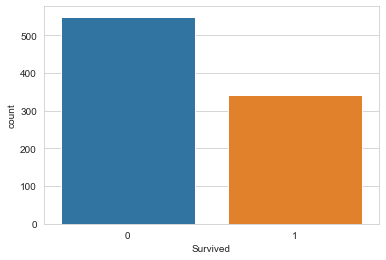

In [58]:
#Let's continue on by visualizing some more of the data! 
sns.set_style("whitegrid")
#whitegrid adds the grid line in the white background
sns.countplot(x='Survived',data=df)
# Can also use directly "sns.countplot('Survived',data=df)""

/Users/siddharthmundada/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

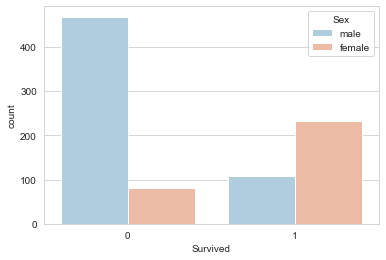

In [59]:
sns.countplot("Survived",hue="Sex",data=df,palette="RdBu_r")
#palette="RdBu_r" just gives different color to the blocks

/Users/siddharthmundada/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

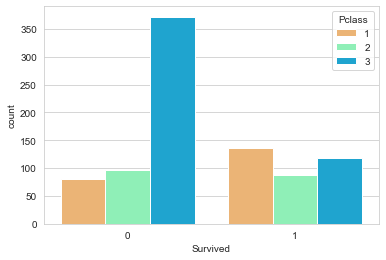

In [60]:
sns.countplot("Survived",hue="Pclass",data=df,palette="rainbow_r")

/Users/siddharthmundada/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

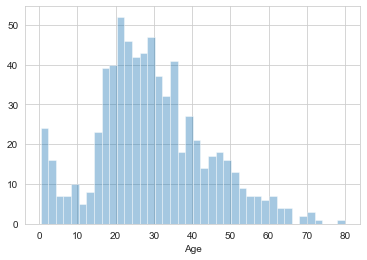

In [61]:
sns.distplot(df["Age"],kde=False,bins=40)

#kde=False will just remove the kernel density estimation.

<AxesSubplot:>

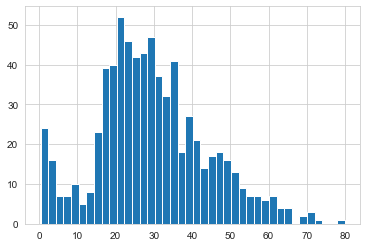

In [62]:
#other way using matplotlib
df["Age"].hist(bins=40)

/Users/siddharthmundada/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SibSp', ylabel='count'>

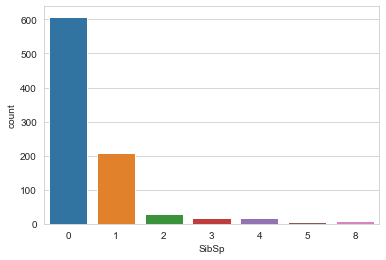

In [63]:
sns.countplot(df["SibSp"])
#or  
# sns.countplot("SibSp",data=df)

<AxesSubplot:>

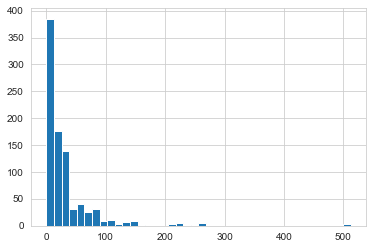

In [64]:
df["Fare"].hist(bins=40)

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation). However we can be smarter about this and check the average age by passenger class. For example:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

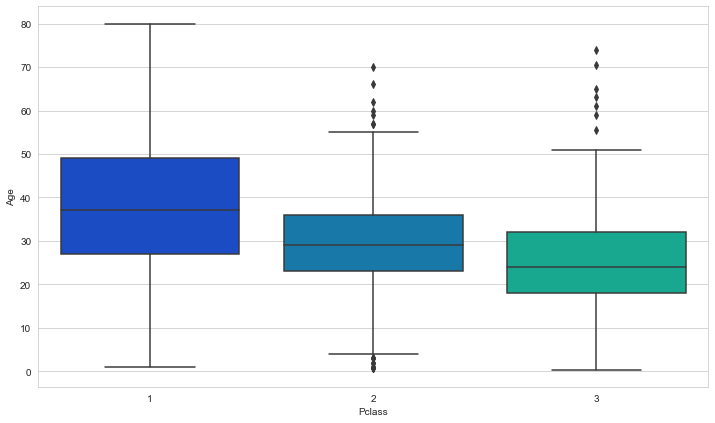

In [65]:
plt.figure(figsize=(12, 7))
sns.boxplot(x="Pclass",y="Age",palette="winter",data=df)

In [66]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We can see the wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [67]:
def impute_age(cols):
    Age=cols[0]
    Pclass=cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else: 
            return 24
        
    else:
        return Age

Now apply that function!

In [68]:
df["Age"]=df[["Age", "Pclass"]].apply(impute_age,axis=1)

In [69]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

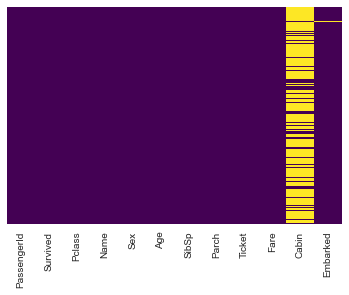

In [70]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

Great! Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [71]:
df.drop("Cabin",axis=1,inplace=True)
#by doing inplace = true the original data set df is also
#update and the Cabin column now will be directly drop from the 
#original data set. IF we have not done inplace = true then the
#original data set would not be updated. and may be you need to do
#df = the drop function

In [72]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


<AxesSubplot:>

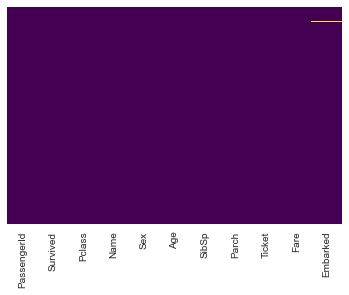

In [73]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [74]:
df.shape

(891, 11)

In [75]:
df =df.dropna(subset=["Embarked"])

<AxesSubplot:>

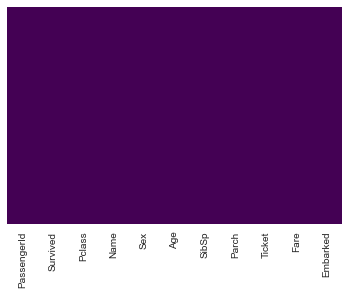

In [76]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [77]:
df.shape

(889, 11)

In [78]:
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


In [80]:
# one hot encoding using dummy of pandas library
# Performing one hot encoding for categorical variables sex and Embarked
# Also note that we are dropping the first column using drop_firs=True. 
# for eg: we dont need to create two variables from Sex variable as male can represent
# boththe variables as if male is 0 means female. Similarly fro embarked if Q=0 and S=0
# it means it is C.
Sex = pd.get_dummies(df["Sex"],drop_first=True)
Embarked =pd.get_dummies(df["Embarked"], drop_first=True)

In [81]:
Sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [82]:
Embarked.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [83]:
# dropping the insignificant variables like PassengerId, Name, Ticket. I'm also dropping 
# Sex and Embarked variables as I will be adding the new onw hot encoded variables to 
# replace them
df_new=df.drop(["PassengerId","Name","Ticket","Sex","Embarked"],axis=1)

In [84]:
df_new.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [86]:
# to append the sex and embarked column to the df_new data set we will use pd.contat
df_new=pd.concat([df_new,Sex,Embarked],axis=1)

In [87]:
df_new.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


### feature engineering is complete data is ready now

## Seperating independent and dependent variables

In [89]:
df_new_target=df_new["Survived"]

In [92]:
df_new_target.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [93]:
df_new=df_new.drop("Survived",axis=1)

In [94]:
df_new.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,3,22.0,1,0,7.2500,1,0,1
1,1,38.0,1,0,71.2833,0,0,0
2,3,26.0,0,0,7.9250,0,0,1
3,1,35.0,1,0,53.1000,0,0,1
4,3,35.0,0,0,8.0500,1,0,1


### creating the train and test split

In [96]:
from sklearn.model_selection import train_test_split

In [97]:
X_train,X_test,Y_train,Y_test=train_test_split(df_new,df_new_target,test_size=0.3)

## Training and Predicting

In [100]:
## Logistic Regression model

In [101]:
from sklearn.linear_model import LogisticRegression

In [104]:
#initialize logistic regression
log_reg=LogisticRegression(penalty='none')
#applying fit method
log_reg.fit(X_train,Y_train)

/Users/siddharthmundada/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

## Accuracy

In [105]:
from sklearn.metrics import accuracy_score

In [106]:
#Predict the train value
Y_train_pred=log_reg.predict(X_train)

#Calculating accuracy for Train 
accuracy_score(Y_train,Y_train_pred)

0.8102893890675241

In [108]:
#Predict the test vale
Y_test_pred=log_reg.predict(X_test)

#Calculating accuracy for test
accuracy_score(Y_test,Y_test_pred)

0.8052434456928839

### Accuracy of train and test is very close indicating that there is no overfitting issue

## Classification Matrix

In [112]:
from sklearn.metrics import confusion_matrix

In [113]:
confusion_matrix(Y_test,Y_test_pred)

array([[148,  16],
       [ 36,  67]])

## Classification Report

In [114]:
from sklearn.metrics import classification_report

In [116]:
print(classification_report(Y_test,Y_test_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       164
           1       0.81      0.65      0.72       103

    accuracy                           0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.80       267



### Calculating the baseline to check if there is any underfitting


In [109]:
# checking the majority class
Y_train.value_counts()

0    385
1    237
Name: Survived, dtype: int64

In [111]:
# Finding the percentage
Y_train.value_counts()/len(Y_train)

0    0.618971
1    0.381029
Name: Survived, dtype: float64

### So the baseline accuracy is 61% and with the logistic model we are getting accuracy of 80.5%, which is way better than the baseline so we also do not have theunderfitting issue